In [ ]:
#Variables de base
base_dir= 'P:/Documents/Projets/power_ai/classif_cni'
train_dir= "P:/Documents/Projets/power_ai/classif_cni/train"
validation_dir= "P:/Documents/Projets/power_ai/classif_cni/valid"
test_dir= "P:/Documents/Projets/power_ai/classif_cni/test"
train_bad_dir= "P:/Documents/Projets/power_ai/classif_cni/train/bad"
train_good_dir = "P:/Documents/Projets/power_ai/classif_cni/train/good"
train_size, validation_size, test_size = 950,100,100
img_w, img_h = 224,224 #Inputs par defaut pour vgg16

In [2]:
#Affichage des images
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

Using TensorFlow backend.


In [3]:
def show(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)
    
    img= image.load_img(img_path, target_size=(img_w, img_h))
    img_tensor= image.img_to_array(img)
    img_tensor/=255.
    plt.imshow(img_tensor)
    plt.show()


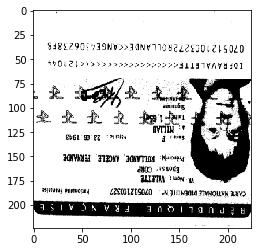

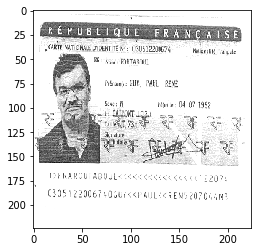

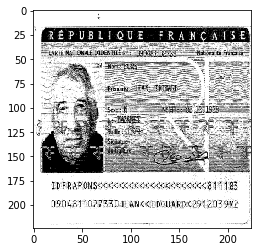

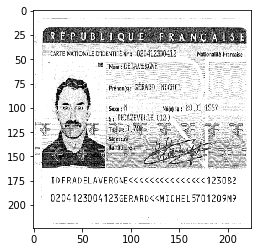

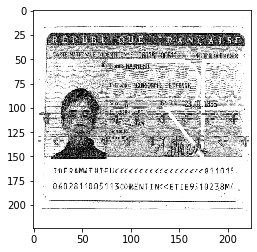

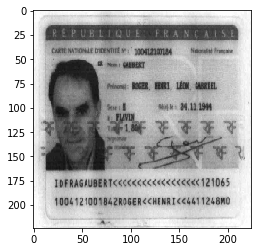

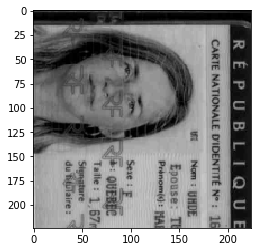

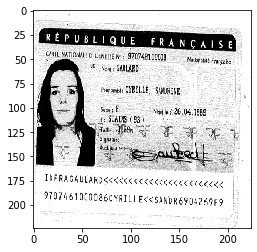

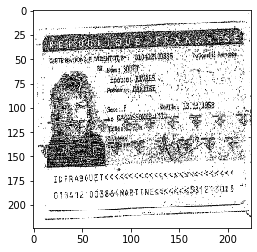

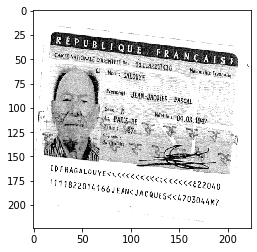

In [4]:
#Afficher 5 images aléatoires de chaque catégorie
for i in range(0,5):
    show(train_bad_dir)
    show(train_good_dir)

In [5]:
#Import du model de cnn pour le transfer learning
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(img_w, img_h,3))

In [6]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
# Extraction des features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Doit etre équivalent à l'output du réseau de convolution
    labels = np.zeros(shape=(sample_count))
    # Preprocessing de la data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_w,img_h),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # On passe la data à travers la réseau de convolution
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size) 
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 950 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [9]:
# On definit le modele
from keras import models
from keras import layers
from keras import optimizers

epochs = 50

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

#On compile
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])
# Entrainnement du modele
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Train on 950 samples, validate on 100 samples
Epoch 1/50
950/950 [==============================] - 4s 4ms/step - loss: 4.0957 - acc: 0.7326 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/50
950/950 [==============================] - 4s 4ms/step - loss: 4.1895 - acc: 0.7368 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/50
950/950 [==============================] - 4s 5ms/step - loss: 2.7221 - acc: 0.7411 - val_loss: 0.8993 - val_acc: 0.8500
Epoch 4/50
950/950 [==============================] - 4s 4ms/step - loss: 0.7710 - acc: 0.8295 - val_loss: 0.4671 - val_acc: 0.8100
Epoch 5/50
950/950 [==============================] - 4s 4ms/step - loss: 0.2877 - acc: 0.8895 - val_loss: 0.2909 - val_acc: 0.9300
Epoch 6/50
950/950 [==============================] - 4s 4ms/step - loss: 0.2448 - acc: 0.8989 - val_loss: 0.3552 - val_acc: 0.8900
Epoch 7/50
950/950 [==============================] - 4s 4ms/step - loss: 0.2032 - acc: 0.9063 - val_loss: 0.3473 - val_acc: 0.8900
Epoch 8/50
950/950 [==========

In [11]:
model.save("vgg16_92.h5")

In [12]:
test_bad_dir= "P:/Documents/Projets/power_ai/classif_cni/test/bad"
test_good_dir= "P:/Documents/Projets/power_ai/classif_cni/test/good"

# Fonction pour visualiser les predictions
def viz_pred(classifier, n_cas):
    for i in range(0,n_cas):
        path = random.choice([test_bad_dir, test_good_dir])

        # Recuperer l'image
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_w, img_h))
        img_tensor = image.img_to_array(img)  # On encode l'image en array
        img_tensor /= 255.  # On normalize

        # Extraction des  features
        features = conv_base.predict(img_tensor.reshape(1,img_w, img_h, 3))

        # On predit
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # On affiche l'image
        plt.imshow(img_tensor)
        plt.show()

        # On affiche la prediction
        if prediction < 0.5:
            print('Bad')
        else:
            print('Good')

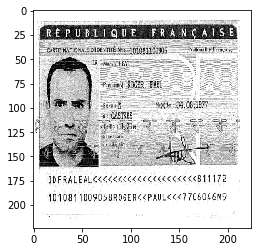

Good


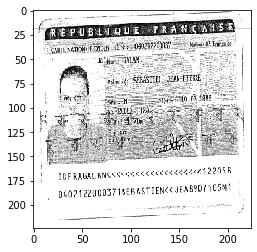

Bad


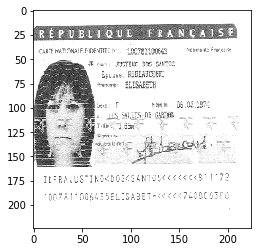

Good


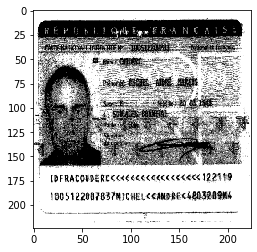

Bad


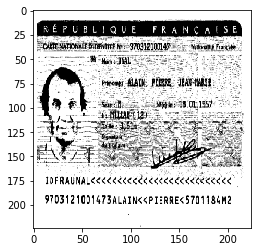

Good


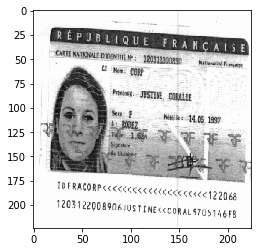

Good


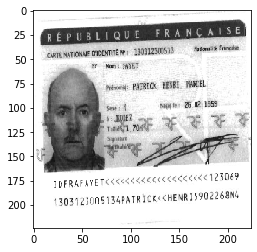

Good


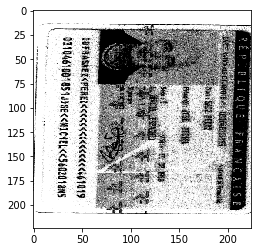

Bad


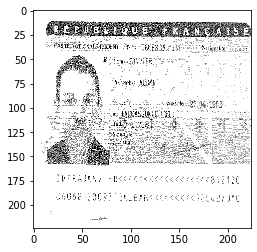

Bad


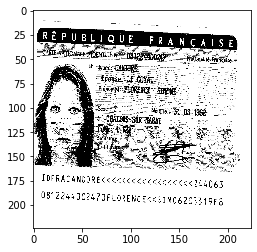

Good


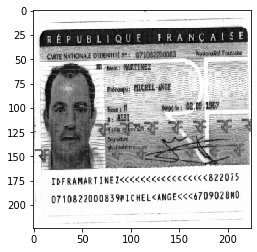

Good


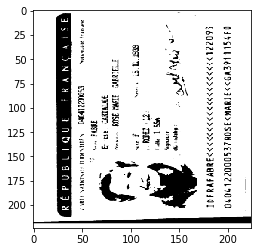

Bad


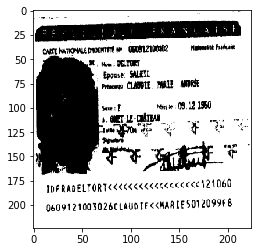

Bad


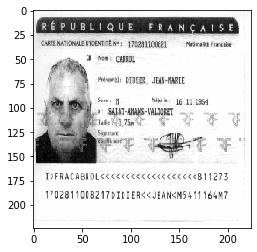

Good


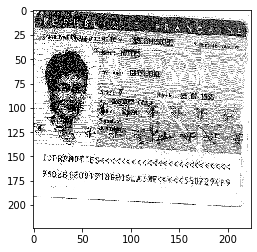

Bad


In [17]:
viz_pred(model, 15)